# Scale factors

Attempts to open this root file: https://gitlab.cern.ch/cms-muonPOG/muonefficiencies/-/tree/master/Run2/UL/2017/2017_trigger
and make plots of lepton scale factors presented here https://github.com/farakiko/boostedhiggs/blob/main/boostedhiggs/corrections.py#L232 and get range and binning from this function https://github.com/farakiko/boostedhiggs/blob/main/boostedhiggs/corrections.py#L342-L344

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

hep.style.use("CMS") 

In [2]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

## Trigger

In [3]:
! ls scalefactors/2017_trigger

Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers.root


In [4]:
# load a root file into coffea-friendly NanoAOD structure
import uproot
f_trigger = uproot.open(f"scalefactors/2017_trigger/Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers.root")
f_trigger.classnames()

{'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_stat;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_syst;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyData;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyData_stat;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyData_syst;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyMC;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyMC_stat;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_abseta_pt_efficiencyMC_syst;1': 'TH2F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_charge_abseta_pt;1': 'TH3F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_charge_abseta_pt_stat;1': 'TH3F',
 'NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium_charge_abseta

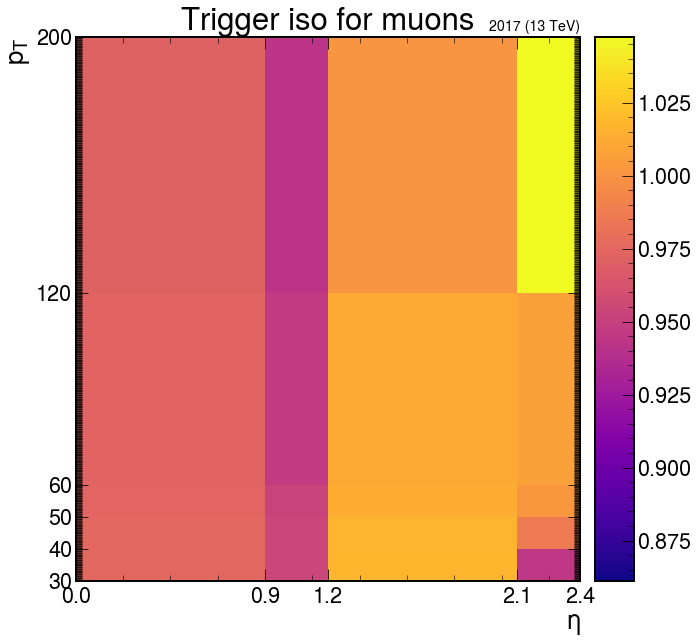

In [7]:
year = '2017'
ch = 'mu'

hists = f_trigger['NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt'].to_hist()

fig, ax = plt.subplots(figsize=(10, 10))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=10000))
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$p_T$")
ax.set_title(f'Trigger iso for muons')
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax, fontsize=15)

ax.set_xlim(0, 2.4)
ax.set_ylim(30, 200);
# hep.cms.text("Work in Progress", ax=ax);
# print(f'saving at {odir}/{ch}_{vars[0]}_{vars[1]}/{sample}_log_z.pdf')
plt.savefig(f'/Users/fmokhtar/Desktop/plots/scalefactors/mu_trigger_iso_pt_eta.pdf')

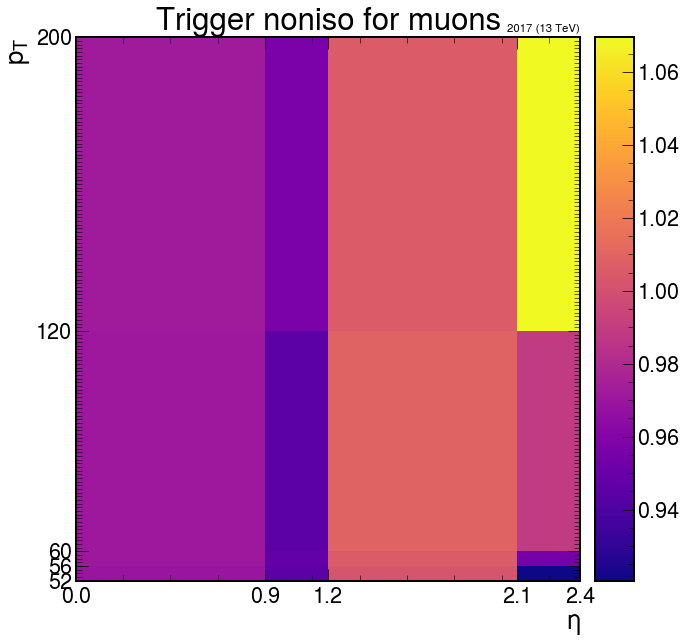

In [8]:
year = '2017'
ch = 'mu'
hep.style.use("CMS") 

hists = f_trigger['NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose_abseta_pt'].to_hist()


fig, ax = plt.subplots(figsize=(10, 10))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=10000))
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$p_T$")
ax.set_title(f'Trigger noniso for muons')
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax, fontsize=12)

ax.set_xlim(0, 2.4)
ax.set_ylim(52, 200);
# hep.cms.text("Work in Progress", ax=ax);
# print(f'saving at {odir}/{ch}_{vars[0]}_{vars[1]}/{sample}_log_z.pdf')
plt.savefig(f'/Users/fmokhtar/Desktop/plots/scalefactors/mu_trigger_noniso_pt_eta.pdf')

## ID

In [9]:
! ls scalefactors/2017_Z/

Efficiencies_muon_generalTracks_Z_Run2017_UL_ID.root
Efficiencies_muon_generalTracks_Z_Run2017_UL_ISO.root


In [10]:
# load a root file into coffea-friendly NanoAOD structure
import uproot
f_id = uproot.open(f"scalefactors/2017_Z/Efficiencies_muon_generalTracks_Z_Run2017_UL_ID.root")
f_id.classnames()

{'NUM_HighPtID_DEN_TrackerMuons_abseta_pt;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_stat;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_syst;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyData;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyData_stat;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyData_syst;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyMC;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyMC_stat;1': 'TH2F',
 'NUM_HighPtID_DEN_TrackerMuons_abseta_pt_efficiencyMC_syst;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt_stat;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt_syst;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt_efficiencyData;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt_efficiencyData_stat;1': 'TH2F',
 'NUM_LooseID_DEN_TrackerMuons_abseta_pt_efficiencyData_syst;1': 'TH2F',
 'NUM_LooseID_DEN

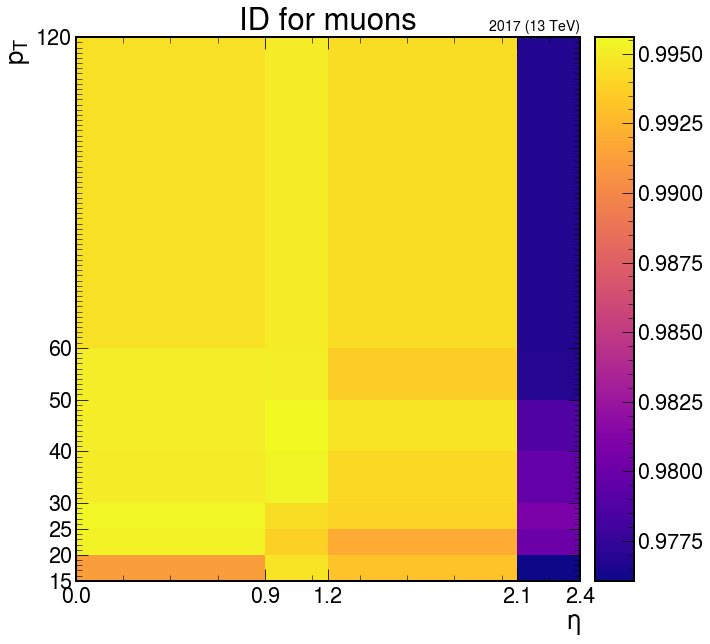

In [11]:
year = '2017'
ch = 'mu'

hists = f_id['NUM_MediumPromptID_DEN_TrackerMuons_abseta_pt'].to_hist()

fig, ax = plt.subplots(figsize=(10, 10))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=10000))
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$p_T$")
ax.set_title(f'ID for muons')
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax, fontsize=15)

# ax.set_xlim(0, 2.4)
# ax.set_ylim(52, 200);
# hep.cms.text("Work in Progress", ax=ax);
# print(f'saving at {odir}/{ch}_{vars[0]}_{vars[1]}/{sample}_log_z.pdf')
plt.savefig(f'/Users/fmokhtar/Desktop/plots/scalefactors/mu_id_pt_eta.pdf')

## ISO

In [12]:
! ls scalefactors/2017_Z/

Efficiencies_muon_generalTracks_Z_Run2017_UL_ID.root
Efficiencies_muon_generalTracks_Z_Run2017_UL_ISO.root


In [13]:
# load a root file into coffea-friendly NanoAOD structure
import uproot
f_iso = uproot.open(f"scalefactors/2017_Z/Efficiencies_muon_generalTracks_Z_Run2017_UL_ISO.root")
f_iso.classnames()

{'NUM_LooseRelIso_DEN_LooseID_abseta_pt;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_stat;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_syst;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyData;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyData_stat;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyData_syst;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyMC;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyMC_stat;1': 'TH2F',
 'NUM_LooseRelIso_DEN_LooseID_abseta_pt_efficiencyMC_syst;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt_stat;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt_syst;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt_efficiencyData;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt_efficiencyData_stat;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abseta_pt_efficiencyData_syst;1': 'TH2F',
 'NUM_LooseRelIso_DEN_MediumID_abse

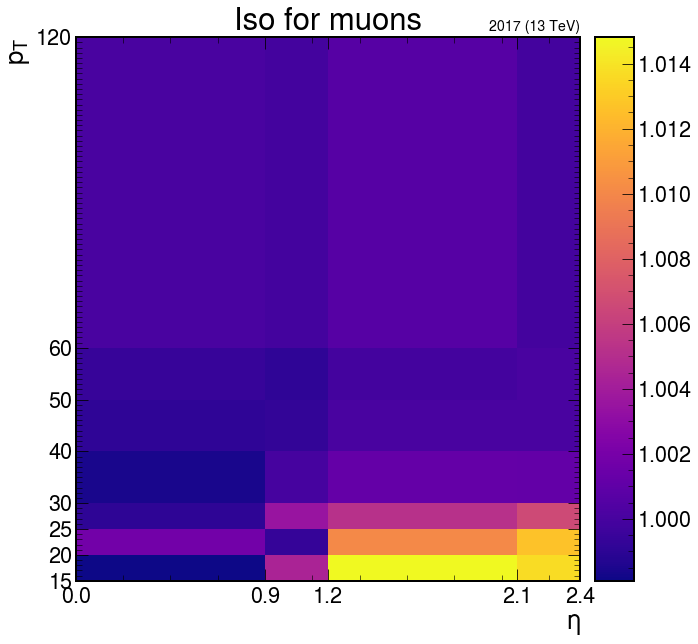

In [14]:
year = '2017'
ch = 'mu'

hists = f_iso['NUM_LooseRelIso_DEN_MediumPromptID_abseta_pt'].to_hist()

fig, ax = plt.subplots(figsize=(10, 10))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=10000))
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$p_T$")
ax.set_title(f'Iso for muons')
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax, fontsize=15)

# ax.set_xlim(0, 2.4)
# ax.set_ylim(52, 200);
# hep.cms.text("Work in Progress", ax=ax);
# print(f'saving at {odir}/{ch}_{vars[0]}_{vars[1]}/{sample}_log_z.pdf')
plt.savefig(f'/Users/fmokhtar/Desktop/plots/scalefactors/mu_iso_pt_eta.pdf')

In [ ]:
#### TODO:
# ID: make plots of corrections -> keep in mind the year
# visual style
# fix notebook 23
# gen electron and first muon are